# Deep Q-Learning

This notebook was kindly provided by [Nilau1998](https://github.com/Nilau1998).

The following Deep Q-Learning algorithm for the Cart Pole problem provided by OpenAIs Gymnasium was implemented using the PyTorch library. The main components of the implementation are:


1. **Experience Replay:**
   - A replay buffer was implemented to store the agent's experiences, consisting of the state, action, reward, next state, and done flag.
   - Mini-batches were sampled from the replay buffer during training to update the neural network, breaking the correlation between consecutive experiences and improving the stability of the learning process.

2. **Epsilon-Greedy Exploration:**
   - An epsilon-greedy policy was used to balance exploration and exploitation. Initially, the exploration rate (epsilon) was set high to encourage exploration.
   - Epsilon was gradually reduced over time, allowing the agent to exploit its learned policy more frequently. This annealing schedule helps transition from exploration to exploitation as training progresses.

3. **Neural Network:**
   - The neural network approximates the Q-values for different state-action pairs. It consists of an input layer for the state representation, hidden layers with ReLU activations, and an output layer predicting the Q-values for each possible action.
   - The architecture and size of the network were chosen to balance computational efficiency and learning capability for the Cart Pole problem.

4. **Target Network:**
   - To stabilize the training process, a target network was used. This separate neural network has the same architecture as the main network.
   - The weights of the target network are periodically updated with the weights of the main network, reducing oscillations and divergence in the learning process by providing a more stable target for the Q-value updates.

5. **Loss Function and Optimization:**
   - The loss function used is the mean squared error (MSE) between the predicted Q-values and the target Q-values.
   - The target Q-values are computed using the reward and the discounted maximum Q-value of the next state, as predicted by the target network.
   - The Adam optimizer was used to update the neural network parameters based on the computed loss, chosen for its adaptive learning rate properties that efficiently handle the gradients during training.

This implementation ensures that the agent learns to balance the pole on the cart by optimizing the expected cumulative reward through interaction with the environment, guided by the Q-learning algorithm and neural network function approximation.

Unlike \textbf{policy gradient} methods, which attempt to learn functions which directly map an observation to an action \textbf{Q-Learning} attempts to learn the value of being in a given state, and taking a specific action there. In it's simplest implementation, Q-Learning is a table of values for every state (row) and action (column) possible in the environment. We make updates to our Q-table using something called the \textbf{Bellman equation}, which states that the expected long-term reward for a given action is equal to the immediate reward from the current action combined with the expected reward from the best future action taken at the following state, e.g. \(Q(s,a) = r + y(max(Q(s',a'))\).

In [239]:
import collections
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import torch.nn as nn
import torch

device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu")

## ReplayBuffer

The `ReplayBuffer` is designed to store and manage experiences for training a reinforcement learning agent. It helps in stabilizing and improving the learning process. By randomly selecting a batch of experiences, it helps to break correlations between consecutive experiences.

In [240]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size
        self.memory = collections.deque([], maxlen=size)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        return [torch.tensor(t).to(device) for t in list(zip(*batch))]

    def store_transition(self, transition):
        self.memory.append(transition)

    def __len__(self):
        return len(self.memory)

## Epsilon Greedy-Policy

Text(0, 0.5, 'Epsilon')

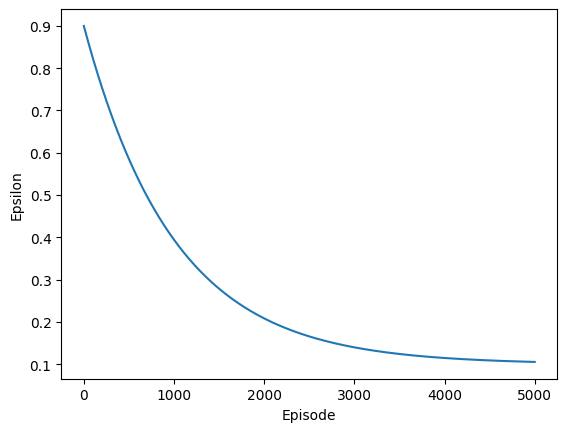

In [241]:
def decay(epsilon_start, epsilon_end, epsilon_decay=1000):
    return lambda episode: epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * episode / epsilon_decay)
eps_decay = decay(0.9, 0.1, 1000)

plt.plot([eps_decay(i) for i in range(5000)])
plt.xlabel("Episode")
plt.ylabel("Epsilon")

## Deep Q Network

- **Architecture**: The neural network consists of three fully connected layers. The first two layers use ReLU activation functions.
  - `fc1`: Input layer to the first hidden layer with 128 units.
  - `fc2`: First hidden layer to the second hidden layer with 64 units.
  - `fc3`: Second hidden layer to the output layer, with a number of units equal to the number of actions.
- **Optimizer**: The Adam optimizer is used with a learning rate of 0.001.

In [242]:
class DeepQNetwork(nn.Module):
    def __init__(self, input_shape, n_actions, lr):
        super().__init__()
        self.fc1 = nn.Linear(*input_shape, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.to(device)

    def forward(self, state):
        x = nn.functional.relu(self.fc1(state))
        x = nn.functional.relu(self.fc2(x))
        return self.fc3(x)

    @torch.no_grad()
    def predict(self, state):
        state = torch.tensor(state, dtype=torch.float32).to(device)
        return self.forward(state).argmax().item()


#### **Agent Class**

- **Initialization**: Initializes the hyperparameters and components such as epsilon for exploration, gamma for discount factor, and two networks (the main Q-network and the target network). Also initializes the replay buffer.
- **Action Selection (choose_action)**: Uses an epsilon-greedy policy to select actions.
  - Epsilon is decayed over time to shift from exploration to exploitation.
  - With probability `epsilon_threshold`, selects a random action; otherwise, selects the action with the highest predicted Q-value.
- **Learning (learn)**: Updates the Q-network using experiences sampled from the replay buffer.
  - If there are not enough experiences, the learning process is skipped.
  - Calculates predicted Q-values for the current state-action pairs.
  - Calculates target Q-values using rewards and the maximum Q-value for the next state, as predicted by the target network.
  - Computes the loss using mean squared error between predicted and target Q-values, and performs a backward pass to update the network weights.
  - Periodically updates the target network parameters to stabilize training.
- **Network Update (update_network_parameters)**: Softly updates the target network parameters using a factor `tau` to blend the weights of the main Q-network and the target network.

In [243]:
class Agent():
    def __init__(self, epsilon, gamma, input_shape, n_actions, tau=0.05):
        self.gamma = gamma
        self.n_actions = n_actions
        self.memory = ReplayBuffer(10000)
        self.dqn = DeepQNetwork(input_shape, n_actions, 0.001)
        self.target = DeepQNetwork(input_shape, n_actions, 0.001)
        self.tau = tau

    def choose_action(self, observation, eps):
        if np.random.random() < eps:
            return self.dqn.predict(observation)
        return np.random.choice(self.n_actions)

    def learn(self, batch_size=64):
        if len(self.memory) < batch_size:
            return

        batch = self.memory.sample(batch_size)
        states, actions, rewards, next_states, dones = batch

        q_pred = self.dqn.forward(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        q_next = self.target.forward(next_states).detach().max(dim=1).values
        q_next[dones] = 0.0
        q_target = rewards + (self.gamma * q_next)

        loss = nn.functional.mse_loss(q_target, q_pred).to(device)
        self.dqn.optimizer.zero_grad()
        loss.backward()
        self.dqn.optimizer.step()
        self.update_network_parameters()

    def update_network_parameters(self):
        target_value_state_dict = self.target.state_dict()
        value_state_dict = self.dqn.state_dict()
        for name in value_state_dict:
            target_value_state_dict[name] = value_state_dict[name] * \
                self.tau + target_value_state_dict[name]*(1-self.tau)
        self.target.load_state_dict(target_value_state_dict)

### Description of the Training Loop and Performance Visualization

The provided script trains a Deep Q-Learning agent on the CartPole-v1 environment using the `Agent` and `ReplayBuffer` classes. The key steps in the training loop and performance visualization are:

#### **Environment Setup and Agent Initialization**

- The CartPole-v1 environment is created using the `gymnasium` library.
- An `Agent` instance is initialized with specified hyperparameters:
  - `epsilon=0.9` for the initial exploration rate.
  - `gamma=0.99` for the discount factor.
  - `input_shape` as the shape of the environment's observation space.
  - `n_actions` as the number of possible actions in the environment.

#### **Training Loop**

- The agent is trained over `n_games = 200` episodes.
- For each episode:
  - The environment is reset, and the initial observation is obtained.
  - The `done` and `truncated` flags are set to `False`.
  - A while loop runs until the episode is completed (`done` or `truncated` is `True`).
  - Within the loop:
    - The agent selects an action using the `choose_action` method.
    - The environment is stepped with the chosen action to get the next state, reward, and completion flags.
    - The transition (current state, action, reward, next state, done) is stored in the agent's replay buffer.
    - The agent performs a learning step using the `learn` method.
    - The observation is updated to the new state.
  - The episode's score (total reward) is recorded.
  - The current epsilon value is recorded.
  - The average score over the last 100 episodes is calculated and recorded.
  - Optional: The progress of the training can be printed every few episodes.

#### **Performance Visualization**

- **Scores Plot**: Shows the scores and average scores over the training episodes.
  - The scores of each episode are plotted.
  - The average scores over the last 100 episodes are plotted to show the trend.
- **Epsilons Plot**: Shows the decay of the epsilon value over the training episodes.
  - Epsilon values are scaled by 100 for better visualization.

Text(0, 0.5, 'Epsilon')

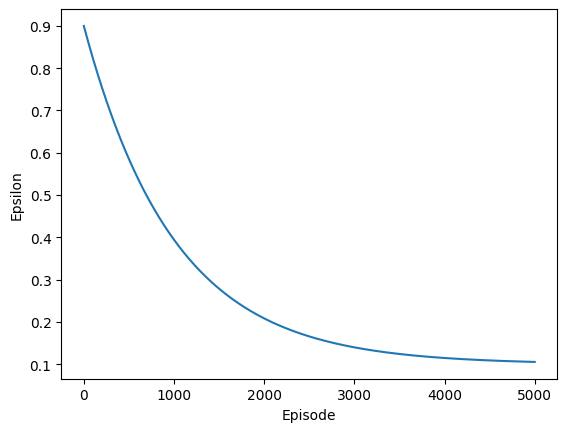

In [244]:
def decay(epsilon_start, epsilon_end, epsilon_decay=1000):
    return lambda episode: epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * episode / epsilon_decay)
eps_decay = decay(0.9, 0.1, 1000)

plt.plot([eps_decay(i) for i in range(5000)])
plt.xlabel("Episode")
plt.ylabel("Epsilon")

In [245]:
env = gym.make('CartPole-v1')
agent = Agent(epsilon=0.9, gamma=0.99, input_shape=env.observation_space.shape, n_actions=env.action_space.n)
scores, epsilons, avg_scores = [], [], []
for i in range(300):
    score = 0
    done, truncated = False, False
    observation = env.reset()[0]
    step = 0
    while not done and not truncated:
        action = agent.choose_action(observation, eps_decay(step))
        observation_, reward, done, truncated, info = env.step(action)
        score += reward
        agent.memory.store_transition([observation, action, reward, observation_, done])
        agent.learn(batch_size=64)
        observation = observation_
        step += 1

    scores.append(score)
    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)

Text(0, 0.5, 'Scores')

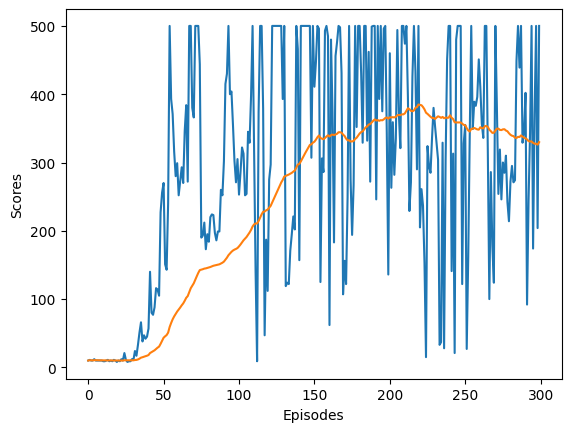

In [248]:
plt.plot(scores, label='Scores')
plt.plot(avg_scores, label='Average Scores')
plt.xlabel('Episodes')
plt.ylabel('Scores')

# Evaluation
The model training stops when it consistently achieves the maximum score and the environment truncates. As expected, the average score continuously increases during training, indicating that the agent is effectively learning to control the CartPole. The epsilon value gradually decreases, meaning the agent relies more on its learned knowledge as training progresses.

During training, it was observed that the number of episodes significantly impacts performance and required fine-tuning. The model presented here needed 200 episodes, but using more episodes sometimes led to catastrophic forgetting, where the model's performance deteriorated in later episodes. Automating this tuning process is challenging. One idea was to track the average score and stop training if it decreases, but this could prematurely halt training if the model is temporarily stuck in a local minimum and might improve in subsequent episodes.

### Evaluation Script

This script evaluates the trained agent on 100 episodes of the CartPole-v1 environment to assess its performance. The key steps are:

- Resetting the environment at the start of each episode.
- Using the trained agent to select actions based on observations.
- Accumulating the score for each episode.
- Recording and printing the score for each evaluation episode.
- Calculating and printing the average score over all evaluation episodes.

Text(0, 0.5, 'Scores')

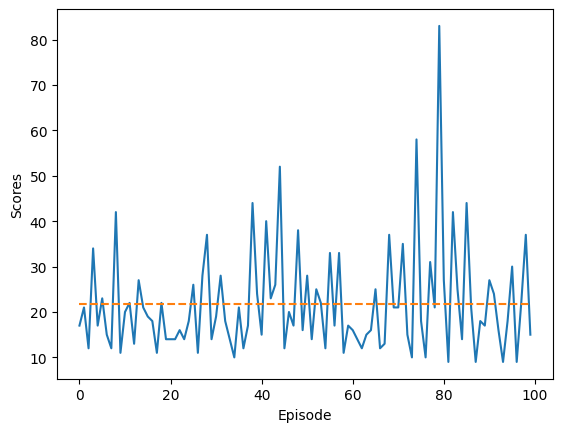

In [ ]:
n_eval_games = 100

eval_scores = []
for i in range(n_eval_games):
    score = 0
    done, truncated = False, False
    observation = env.reset()[0]
    while not done and not truncated:
        action = agent.choose_action(observation, 0)
        observation_, reward, done, truncated, info = env.step(action)
        score += reward
        observation = observation_
    eval_scores.append(score)

plt.plot(eval_scores)
plt.plot([np.mean(eval_scores)] * n_eval_games, linestyle='--')
plt.xlabel('Episode')
plt.ylabel('Scores')